In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('coded_final.csv')
#df = pd.read_csv('flying-etiquette.csv')

In [51]:
df.head()

,RespondentID,How often do you travel by plane?,Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,"In a row of three seats, who should get to use the two arm rests?","In a row of two seats, who should get to use the middle arm rest?",Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?",...,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Age,Household Income,Education,Location (Census Region)
0,3436139758,Once a year or less,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3434278696,Once a year or less,About half the time,"6'3""",Yes,The arm rests should be shared,The arm rests should be shared,Everyone in the row should have some say,"No, not rude at all","No, not at all rude",...,"No, not at all rude","No, not at all rude","No, not at all rude",No,No,Male,30-44,NaN,Graduate degree,Pacific
2,3434275578,Once a year or less,Usually,"5'8""",No,Whoever puts their arm on the arm rest first,The arm rests should be shared,The person in the window seat should have excl...,"No, not rude at all","No, not at all rude",...,"Yes, somewhat rude","Yes, somewhat rude","Yes, very rude",No,No,Male,30-44,"$100,000 - $149,999",Bachelor degree,Pacific
3,3434268208,Once a year or less,Always,"5'11""",No,The arm rests should be shared,The arm rests should be shared,Everyone in the row should have some say,"No, not rude at all","No, not at all rude",...,"Yes, somewhat rude","Yes, somewhat rude","Yes, very rude",No,No,Male,30-44,"$0 - $24,999",Bachelor degree,Pacific
4,3434250245,Once a month or less,About half the time,"5'7""",No,The person in the middle seat gets both arm rests,The person in aisle,Everyone in the row should have some say,"No, not rude at all","No, not at all rude",...,"Yes, somewhat rude","Yes, somewhat rude","Yes, very rude",Yes,No,Male,30-44,"$50,000 - $99,999",Bachelor degree,Pacific


In [52]:
import plot_likert
ax_list = []
idx_list = []
for index, column in enumerate(df.columns):
    if column not in ['RespondentID']:
        print(df[column].unique())
        ax_list.append(plot_likert.plot_likert(df[column]+1.0, df[column].unique()+1.0, bar_labels=True, width = 0.15, label=0))
        idx_list.append(index)

#plot all the axes
fig, axes = plt.subplots(nrows=len(ax_list), ncols=1, figsize=(10, 10))
for index, ax in enumerate(ax_list):
    ax.plot(ax=axes[index])
    ax.set_title(df.columns[idx_list[index]])
    ax.set_yticklabels('')
plt.tight_layout()
plt.show()

['Once a year or less' 'Once a month or less' 'Never'
 'A few times per week' 'Every day' 'A few times per month']


TypeError: can only concatenate str (not "float") to str

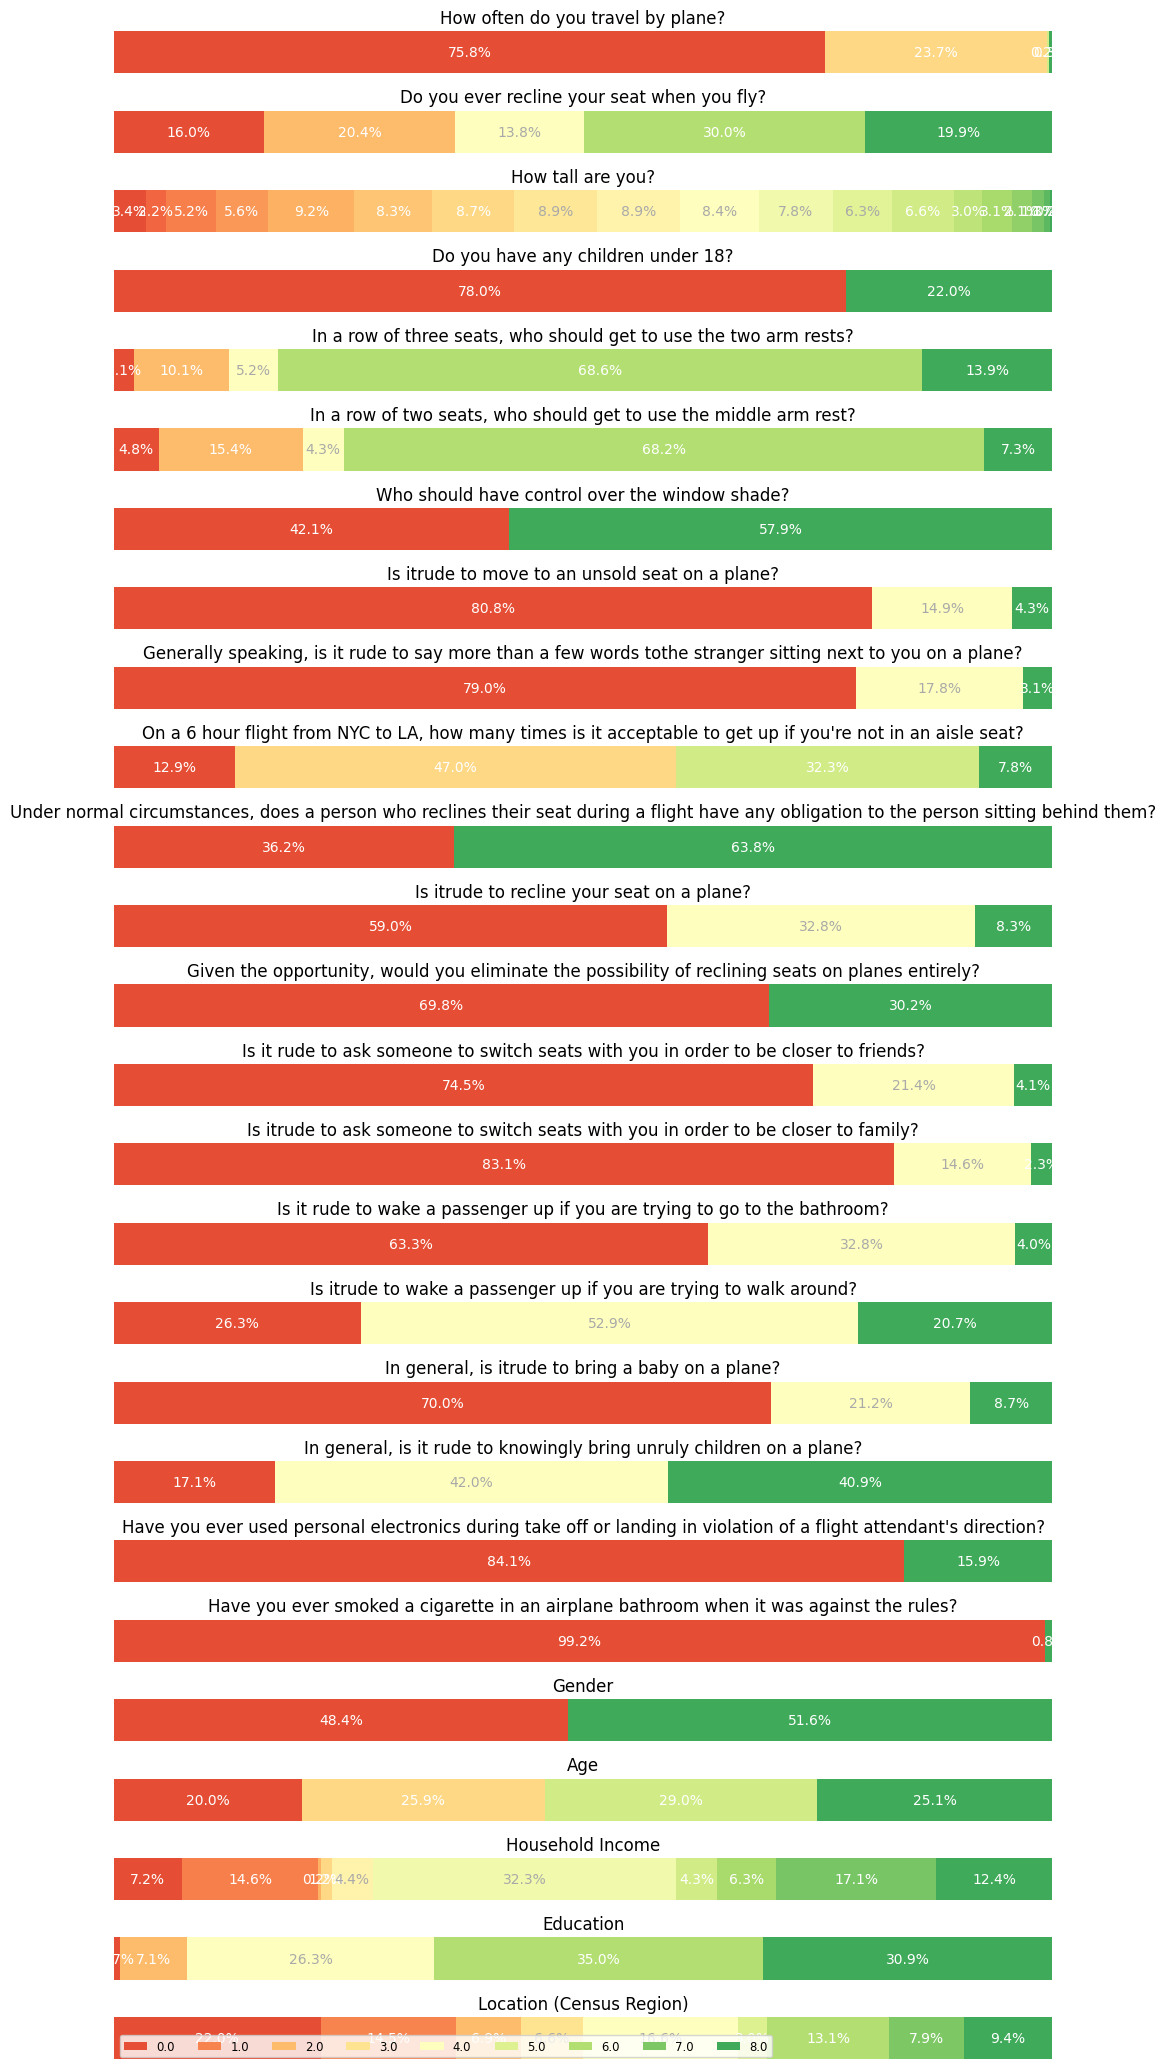

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def adapted_survey(axes, question, answers, category_names, index):
    """
    Adapted survey function to handle variable number of answers per question and plot on a given axis.
    """
    # Count the frequency of each answer and ensure the order is numerical
    answer_counts = answers.value_counts().reindex(category_names, fill_value=0).sort_index()
    total_answers = answer_counts.sum()

    # Prepare data for plotting
    data = np.array(answer_counts)
    data_cum = data.cumsum()
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, len(category_names)))

    ax = axes[index] if len(axes) > 1 else axes
    ax.invert_xaxis()
    ax.set_ylim(-0.25, 0.25)  # Makes bars thinner
    ax.yaxis.set_visible(False)
    ax.set_xlim(0, np.max(data_cum))
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Hide the spines (borders)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set and adjust the position of the title
    ax.set_title(question, loc='center')
    ax.title.set_position([.5, 1.02])  # Further adjust title position

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        width = data[i]
        start = data_cum[i] - width
        ax.barh([question], width, left=start, height=0.5, label=colname, color=color)

        # Calculate and format the percentage
        percentage = (width / total_answers) * 100
        text = f'{percentage:.1f}%'  # Format to 1 decimal place

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.text(start + width / 2, 0, text, ha='center', va='center', color=text_color)

    if index == len(axes) - 1:  # Add legend only once
        ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.1), loc='lower left', fontsize='small')

# Usage with your DataFrame
question_columns = [column for column in df.columns if column not in ['RespondentID']]
total_questions = len(question_columns)

# Adjust the height of each subplot here
subplot_height = 0.8  # Decrease this value to reduce vertical spacing
fig, axes = plt.subplots(total_questions, 1, figsize=(10, total_questions * subplot_height), squeeze=False)
axes = axes.flatten()

for index, column in enumerate(question_columns):
    unique_answers = np.sort(df[column].unique())
    adapted_survey(axes, column, df[column], unique_answers, index)

# Adjust the spacing of the subplots here
plt.subplots_adjust(hspace=0.5)  # Decrease this value to reduce spacing between subplots

plt.tight_layout()
plt.show()


In [9]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,RespondentID,How often do you travel by plane?,Do you ever recline your seat when you fly?,Do you have any children under 18?,Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,"Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?",Is it rude to ask someone to switch seats with you in order to be closer to friends?,Is itrude to ask someone to switch seats with you in order to be closer to family?,Is it rude to wake a passenger up if you are trying to go to the bathroom?,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Household Income,Education,Location (Census Region)
RespondentID,1.000000,0.021625,-0.015843,-0.022741,-0.066849,0.020482,0.039158,0.104820,0.040150,-0.047809,-0.016874,0.102970,0.045258,-0.043971,-0.031457,0.015626,0.003829,-0.028416,0.005418,-0.261733,-0.067615,-0.008335,-0.031399
How often do you travel by plane?,0.021625,1.000000,-0.009314,-0.023420,0.022836,-0.057648,-0.042614,0.008884,0.056399,-0.105118,-0.058495,-0.019034,-0.056168,-0.052442,0.040365,-0.051300,-0.012186,-0.201084,-0.240017,0.038965,-0.264177,-0.221369,0.013471
Do you ever recline your seat when you fly?,-0.015843,-0.009314,1.000000,-0.046649,0.020249,0.067699,0.060408,0.080337,0.382798,0.515390,0.401736,0.038480,0.033391,0.007597,0.053686,-0.002774,0.002252,-0.121906,-0.058555,-0.015669,-0.017903,-0.012166,0.025230
Do you have any children under 18?,-0.022741,-0.023420,-0.046649,1.000000,0.016180,-0.023581,-0.053721,-0.004319,-0.024322,-0.073950,-0.068244,0.004090,-0.026655,-0.004470,-0.002302,-0.160285,-0.213576,-0.040712,0.045287,-0.023335,0.087101,0.023069,-0.012349
Who should have control over the window shade?,-0.066849,0.022836,0.020249,0.016180,1.000000,-0.022682,-0.042176,-0.077756,0.112846,-0.028250,-0.019704,-0.082179,-0.110448,-0.011895,-0.042005,-0.073334,-0.050744,-0.077919,-0.054504,0.029293,0.032968,0.052535,0.007274
Is itrude to move to an unsold seat on a plane?,0.020482,-0.057648,0.067699,-0.023581,-0.022682,1.000000,0.228318,0.071082,0.033922,0.128089,0.084070,0.240077,0.225459,0.099353,0.130140,0.097772,0.073564,-0.041826,0.085049,-0.047418,-0.104394,-0.122562,0.019454
"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?",0.039158,-0.042614,0.060408,-0.053721,-0.042176,0.228318,1.000000,0.107464,0.031261,0.155134,0.119054,0.136300,0.144095,0.147326,0.122639,0.210942,0.104410,0.021499,0.060857,0.002694,-0.010676,0.005086,0.033809
"On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?",0.104820,0.008884,0.080337,-0.004319,-0.077756,0.071082,0.107464,1.000000,0.017505,0.078994,0.092688,0.134944,0.127673,0.173034,0.254337,0.032252,0.020783,0.018705,0.039229,0.067805,-0.032595,-0.058349,0.027404
"Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",0.040150,0.056399,0.382798,-0.024322,0.112846,0.033922,0.031261,0.017505,1.000000,0.373565,0.239914,-0.012058,-0.027205,0.046859,0.044675,-0.015835,0.027764,-0.103466,-0.012245,0.053964,-0.046892,-0.021801,0.026319
Is itrude to recline your seat on a plane?,-0.0

      How often do you travel by plane?  \
2                                   4.0   
3                                   4.0   
4                                   3.0   
5                                   4.0   
6                                   3.0   
...                                 ...   
1027                                4.0   
1028                                4.0   
1032                                4.0   
1035                                4.0   
1039                                4.0   

      Do you ever recline your seat when you fly?  How tall are you?  \
2                                             1.0             172.72   
3                                             0.0             180.34   
4                                             2.0             170.18   
5                                             1.0             175.26   
6                                             3.0             187.96   
...                                           ...  

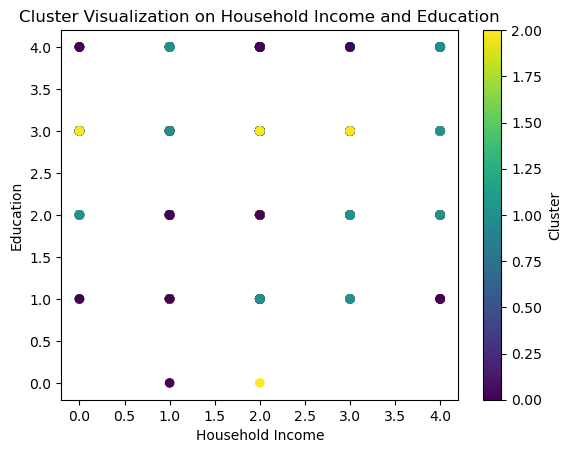

In [11]:
from sklearn.cluster import KMeans

# Filter the dataframe to include only rows with float values
filtered_df = df.select_dtypes(include=['float'])

# Drop rows with NaN values
filtered_df = filtered_df.dropna()


# Create an instance of KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=3)

# Fit the data to the KMeans model
kmeans.fit(filtered_df)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataframe
filtered_df['Cluster'] = cluster_labels

# Print the updated dataframe
print(filtered_df)
df = filtered_df

plt.scatter(df['Household Income'], df['Education'], c=df['Cluster'])
plt.xlabel('Household Income')
plt.ylabel('Education')
plt.title('Cluster Visualization on Household Income and Education')
plt.colorbar(label='Cluster')
plt.show()


In [12]:
df.head()

,How often do you travel by plane?,Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,...,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Household Income,Education,Location (Census Region),Cluster
2,4.0,1.0,172.72,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,1.0,1.0,2.0,0.0,0.0,0.0,3.0,3.0,0.0,1
3,4.0,0.0,180.34,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,2
4,3.0,2.0,170.18,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,1.0,1.0,2.0,1.0,0.0,0.0,2.0,3.0,0.0,1
5,4.0,1.0,175.26,1.0,0.0,1.0,0.0,4.0,1.0,0.0,...,2.0,2.0,2.0,0.0,0.0,0.0,1.0,4.0,1.0,1
6,3.0,3.0,187.96,1.0,1.0,0.0,1.0,3.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,2


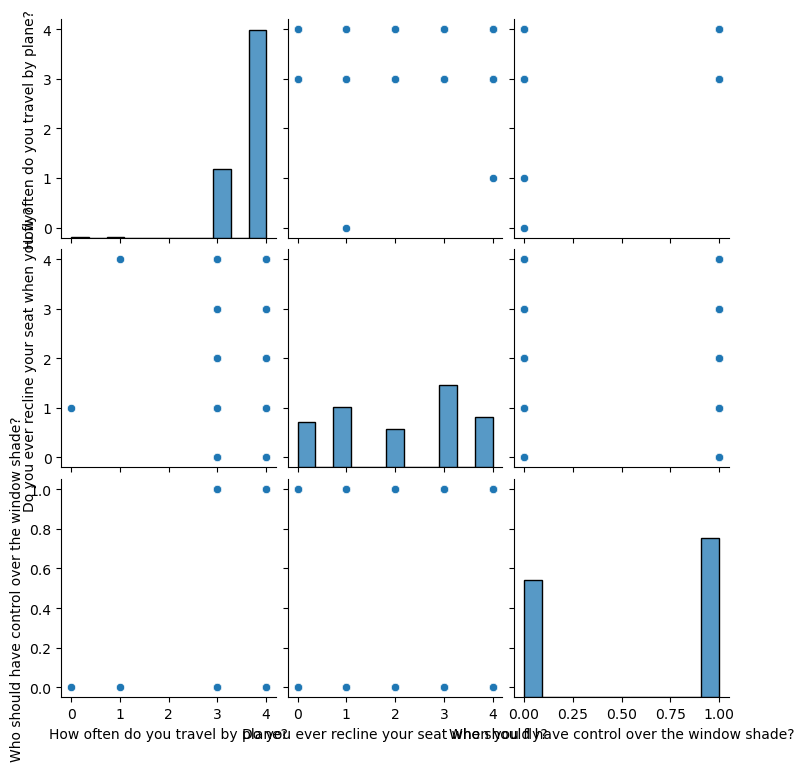

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Selecting relevant columns
selected_columns = ['How often do you travel by plane?', 'Do you ever recline your seat when you fly?',  
                    'Who should have control over the window shade?']

# Creating a subset DataFrame with selected columns
subset_df = df[selected_columns]

# Create a pair plot
sns.pairplot(subset_df)
plt.show()


In [16]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Select two categorical variables
var1 = 'Do you ever recline your seat when you fly?'
var2 = 'Who should have control over the window shade?'

# Create contingency table
contingency_table = pd.crosstab(df[var1], df[var2])

# Output the table
print(contingency_table)


Who should have control over the window shade?  0.0  1.0
Do you ever recline your seat when you fly?             
0.0                                              47   49
1.0                                              51   78
2.0                                              35   46
3.0                                              68  108
4.0                                              49   58


In [19]:
import pandas as pd
from scipy.stats import chi2_contingency
df = pd.read_csv('coded.csv')

# Create a contingency table
contingency_table = pd.crosstab(df['Household Income'], df['How often do you travel by plane?'])

print(contingency_table)
# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")


How often do you travel by plane?  0.0  1.0  3.0  4.0  5.0
Household Income                                          
0.0                                  1    0    5   55   37
1.0                                  1    0   18  105   34
2.0                                  0    1   62  191   36
3.0                                  0    0   36  103   12
4.0                                  0    1   41   52    9
Chi-Square Statistic: 94.13931938665753
P-value: 4.2933924080440987e-13
